# Flood Segmentation with Deep Learning Model

## Libraries

In [1]:
# Import the required Libraries

print("Importing packages.......")

import gc
import os
import numpy as np

from osgeo import gdal
import tensorflow.keras
import tensorflow as tf
import util

import pickle
import matplotlib.pyplot as plt 
import sys
import random
import cv2
# import losses 
import matplotlib.pyplot as plt 

import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

%matplotlib inline
%pylab inline

pylab.rcParams['figure.figsize'] = (15, 10)
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from skimage import exposure
from sklearn.model_selection import train_test_split
import pandas as pd
from skimage import (img_as_float,
                    img_as_ubyte,
                    img_as_uint,
                    img_as_int,
                    io
                    )          
import cv2

from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras import backend as keras
from tensorflow.python.keras import backend as K
from tensorflow.keras.applications import VGG19, densenet

sess = K.get_session()
from tensorflow.compat.v1.keras.backend import set_session
from tensorflow.keras.layers import LeakyReLU

from sklearn.metrics import roc_curve, auc, precision_recall_curve # roc curve tools
from sklearn.model_selection import train_test_split

import imgaug as ia
import imgaug.augmenters as iaa
import segmentation_models as sm

# print("Installing packages.......")

# !pip install keras-tqdm
# from keras_tqdm import TQDMCallback, TQDMNotebookCallback

# !pip install ipython-autotime
# %load_ext autotime

print("Libraries imported")

Importing packages.......
Populating the interactive namespace from numpy and matplotlib


C:\Users\kusha\anaconda3\envs\DL\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['random']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


Segmentation Models: using `tf.keras` framework.
Libraries imported


## Loading the data

### Load and pre-process the arrays

In [2]:
DataFolder = 'D:/Research/PhD/Flood Detection Sydney/Data'

In [3]:
def readdata(directory, folder_name):
      
    data_path = os.path.join(directory, folder_name)
    data_list = {}

    for f in sorted(os.listdir(data_path)):
        fdir = os.path.join(data_path, f)
        _, ext = os.path.splitext(f)
        if ext.lower() == ".tif":
            imgtype = f[-55:-4] # Number of characters of the image file. Example, "Image_1.tif" = 11 characters
            image_data=gdal.Open(fdir)
            bands = [image_data.GetRasterBand(i+1).ReadAsArray() for i in range(image_data.RasterCount)]
            data_list[imgtype] = np.stack(bands, axis=2) 

    return data_list

In [4]:
image_list = readdata(directory=DataFolder, folder_name="Stacks")
label_list = readdata(directory=DataFolder, folder_name="Masks")

In [5]:
# Print all the stacks that are collected
print("The collection of stacks available in the image list are:")
print("-"*30)
print(*image_list, sep='\n')

The collection of stacks available in the image list are:
------------------------------
PCA_24
SEECWSWI_frame2_1
SEECWSWI_frame2_2
SEECW_frame2_1
SEECW_frame2_2
coherence_20210324_VH
coherence_20210324_VV
md_sigma_energy_entropy_coherence_water_20210324_VH
energy_20210324_VH
energy_20210324_VV
energy_entropy_20210324_VH
energy_entropy_20210324_VV
entropy_20210324_VH
entropy_20210324_VV
sigma_20210312_VH
sigma_20210312_VV
sigma_20210324_VH
sigma_20210324_VV
sigma_energy_entropy_20210324_VH
sigma_energy_entropy_20210324_VV
sigma_energy_entropy_coherence_20210324_VH
sigma_energy_entropy_coherence_20210324_VV
sigma_energy_entropy_coherence_water_20210324_VH


In [6]:
# Print all the stacks that are collected
print("The collection of masks available in the image list are:")
print("-"*30)
print(*label_list, sep='\n')

The collection of masks available in the image list are:
------------------------------
SEECW_frame2_1_mask
SEECW_frame2_2_mask
flood_mask


In [7]:
#Check If Everything Works (CIEW)
print("Number of satellite images = " + str(len(image_list)))
print("Shape of the sample image = "+ str(image_list["SEECW_frame2_1"].shape))

print("Number of label images = " + str(len(label_list)))
print("Shape of the image = "+ str(label_list["SEECW_frame2_1_mask"].shape))

Number of satellite images = 23
Shape of the sample image = (1734, 2279, 5)
Number of label images = 3
Shape of the image = (1734, 2279, 1)


In [8]:
def gridwise_sample(imgarray, patchsize):

    """Extract sample patches of size patchsize x patchsize from an image (imgarray) in a gridwise manner.
    """
    nrows, ncols, nbands = imgarray.shape
    patchsamples = np.zeros(shape=(0, patchsize, patchsize, nbands),
                            dtype=imgarray.dtype)
    for i in range(int(nrows/patchsize)):
        for j in range(int(ncols/patchsize)):
            tocat = imgarray[i*patchsize:(i+1)*patchsize,
                             j*patchsize:(j+1)*patchsize, :]
            tocat = np.expand_dims(tocat, axis=0)
            patchsamples = np.concatenate((patchsamples, tocat),
                                          axis=0)
    return patchsamples

In [9]:
# FOR GENERATING TRAINING SITES

PATCHSIZE = 128
NBANDS = 5 # According to the stack, change the number of bands here.

Xtrain = np.zeros(shape=(0, PATCHSIZE, PATCHSIZE, NBANDS), dtype=np.float32)
Ytrain = np.zeros(shape=(0, PATCHSIZE, PATCHSIZE, 1), dtype=np.float32)

# Sample each training tile systematically in a gridwise manner
train_areas = ["sigma_energy_entropy_coherence_water_20210324_VH"] # Choose the required stack for your use case
train_areas_mask = ["flood_mask"] # The mask has already been made for you. Simply put the associated masks here

for area in train_areas:
    X_toadd = gridwise_sample(image_list[area], PATCHSIZE)
    Xtrain = np.concatenate((Xtrain, X_toadd), axis=0)
    Xtrain = Xtrain.astype('uint16')
    
for area_mask in train_areas_mask:
    Y_toadd = gridwise_sample(label_list[area_mask], PATCHSIZE)
    Ytrain = np.concatenate((Ytrain, Y_toadd), axis=0)
    Ytrain = Ytrain.astype('uint16')

# Encode all flood and background labels into their respective classes "0" and "1" (Categorical)
Ytrain[Ytrain==0] = 0
Ytrain[Ytrain!=0] = 1

print("There are %i number of training patches" % (Xtrain.shape[0]))
print(f'Data type of Xtrain is {Xtrain.dtype}')
print(f'Data type of Ytrain is {Ytrain.dtype}')

There are 400 number of training patches
Data type of Xtrain is uint16
Data type of Ytrain is uint16


In [10]:
#CIEW for training patches
bd_px=len(Ytrain[Ytrain==1])/(len(Ytrain[Ytrain==1])+len(Ytrain[Ytrain==0]))
bg_px=len(Ytrain[Ytrain==0])/(len(Ytrain[Ytrain==1])+len(Ytrain[Ytrain==0]))

print("Pixel percentage of flood = " + str(bd_px* 100)+ " %") 
print("Pixel percentage of background = " + str(bg_px* 100)+ " %")

Pixel percentage of flood = 0.75836181640625 %
Pixel percentage of background = 99.24163818359375 %


### Remove Zero Patches

In [11]:
def remove_zeros(images_array,masks_array):
    
    all_zeros = []
    for i in range(masks_array.shape[0]):
        if masks_array[i].max() == 0:
            all_zeros.append(i)
    print("There are: {} arrays with just 0 values, and {} arrays with non zero values ".format(len(all_zeros), (
                images_array.shape[0] - len(all_zeros))))
    images = []
    masks = []
    for i in range(images_array.shape[0]):
        if i not in all_zeros:
            images.append(images_array[i])
            masks.append(masks_array[i])

    # Convert to array
    images = np.array(images, dtype="float64")
    masks = np.array(masks, dtype="float32")
    print("Image shape: {}, Mask shape: {}".format(images.shape, masks.shape))
    return images, masks

In [12]:
X_train, Y_train = remove_zeros(Xtrain, Ytrain)

print("----"*15)

# X_test, Y_test = remove_zeros(Xtest, Ytest)

print("----"*15)

print("There are %i number of training patches" % (X_train.shape[0]))
# print("There are %i number of testing patches" % (X_test.shape[0]))

There are: 366 arrays with just 0 values, and 34 arrays with non zero values 
Image shape: (34, 128, 128, 5), Mask shape: (34, 128, 128, 1)
------------------------------------------------------------
------------------------------------------------------------
There are 34 number of training patches


In [13]:
#CIEW for training patches
bd_px=len(Y_train[Y_train==1])/(len(Y_train[Y_train==1])+len(Y_train[Y_train==0]))
bg_px=len(Y_train[Y_train==0])/(len(Y_train[Y_train==1])+len(Y_train[Y_train==0]))

print("Pixel percentage of flood = " + str(bd_px* 100)+ " %") 
print("Pixel percentage of background = " + str(bg_px* 100)+ " %")

Pixel percentage of flood = 8.921903722426471 %
Pixel percentage of background = 91.07809627757352 %


In [14]:
# Try augmentations..........
print(X_train.shape)
print(Y_train.shape)

seq = iaa.Sequential([
    iaa.Fliplr(1)
])
seq1 = iaa.Sequential([
    iaa.Flipud(1)
])

seq2 = iaa.Sequential([
    iaa.ShearX((-20, 20))
])

seq3 = iaa.Sequential([
    iaa.ShearY((-20, 20))
])

seq4 = iaa.Sequential([
    iaa.Rotate((-45, 45))
])

# Horizontal Flip
X_aug, Y_aug = seq(images=X_train, heatmaps=Y_train)

# Vertical Flip
X_aug1, Y_aug1 = seq1(images=X_train, heatmaps=Y_train)

# Shear X
X_aug2, Y_aug2 = seq2(images=X_train, heatmaps=Y_train)

# Shear Y
X_aug3, Y_aug3 = seq3(images=X_train, heatmaps=Y_train)

# Rotate +-45
X_aug4, Y_aug4 = seq4(images=X_train, heatmaps=Y_train)

X_train = np.concatenate((X_train, X_aug1, X_aug2, X_aug3,  X_aug4), axis=0)
Y_train = np.concatenate((Y_train, Y_aug1, Y_aug2, Y_aug3,  Y_aug4), axis=0)

print(X_train.shape)
print(Y_train.shape)

(34, 128, 128, 5)
(34, 128, 128, 1)
(170, 128, 128, 5)
(170, 128, 128, 1)


In [15]:
# Re-tag into new variables. All training and testing images will be saved into a new variable
X_train, X_test, Y_train, Y_test = train_test_split(X_train, Y_train, test_size=0.33, random_state=42)

In [16]:
# CIEW for pixel-class ratio within the patches 

print("-"*50)

# For training set
ls_px_train=len(Y_train[Y_train==1])/(len(Y_train[Y_train==1])+len(Y_train[Y_train==0]))
bg_px_train=len(Y_train[Y_train==0])/(len(Y_train[Y_train==1])+len(Y_train[Y_train==0]))

print("Pixel percentage of the Background Class on the Training Set = " + str(bg_px_train* 100)+ " %")
print("Pixel percentage of Flood Class on the Training Set = " + str(ls_px_train* 100) + " %") 

print("-"*50)

# For testing set
ls_px_test=len(Y_test[Y_test==1])/(len(Y_test[Y_test==1])+len(Y_test[Y_test==0]))
bg_px_test=len(Y_test[Y_test==0])/(len(Y_test[Y_test==1])+len(Y_test[Y_test==0]))

print("Pixel percentage of the Background Class on the Testing Set = " + str(bg_px_test* 100)+ " %")
print("Pixel percentage of Flood Class on the Testing Set = " + str(ls_px_test* 100) + " %") 

--------------------------------------------------
Pixel percentage of the Background Class on the Training Set = 91.9497964446729 %
Pixel percentage of Flood Class on the Training Set = 8.0502035553271 %
--------------------------------------------------
Pixel percentage of the Background Class on the Testing Set = 91.97678144594174 %
Pixel percentage of Flood Class on the Testing Set = 8.023218554058268 %


In [17]:
print(f'Shape of the training satellite image = {X_train.shape}')
print(f'Shape of the training mask image = {Y_train.shape}')
print("-"*58)
print(f'Shape of the testing satellite image = {X_test.shape}')
print(f'Shape of the testing mask image = {Y_test.shape}')

Shape of the training satellite image = (113, 128, 128, 5)
Shape of the training mask image = (113, 128, 128, 1)
----------------------------------------------------------
Shape of the testing satellite image = (57, 128, 128, 5)
Shape of the testing mask image = (57, 128, 128, 1)


In [18]:
# Normalise the values of the satellite image between 0 and 1
norm_X_train = (X_train - X_train.min())/(X_train.max() - X_train.min())

# print(norm_Xtrain)
print(norm_X_train.max())
print(norm_X_train.min())

1.0
0.0


## Define loss functions and metrics for various accuracies 

In [19]:
# Define the evaluation metrics - Precision, Recall, FScore, IoU
metrics_sm = [sm.metrics.Precision(threshold=0.5),sm.metrics.Recall(threshold=0.5),sm.metrics.FScore(threshold=0.5,beta=1),sm.metrics.IOUScore(threshold=0.5)]

In [20]:
# Losses

# Tversky
def tversky(y_true, y_pred):
    
    y_true_pos = K.flatten(y_true)
    y_pred_pos = K.flatten(y_pred)
    true_pos = K.sum(y_true_pos * y_pred_pos)
    false_neg = K.sum(y_true_pos * (1-y_pred_pos))
    false_pos = K.sum((1-y_true_pos)*y_pred_pos)
    alpha = 0.7
    return (true_pos + K.epsilon())/(true_pos + alpha*false_neg + (1-alpha)*false_pos + K.epsilon())

def tversky_loss(y_true, y_pred, alpha=0.30, beta=0.70):
  
    """
    Function to calculate the Tversky loss for imbalanced data
    :param prediction: the logits
    :param ground_truth: the segmentation ground_truth
    :param alpha: weight of false positives
    :param beta: weight of false negatives
    :param weight_map:
    :return: the loss
    """
    '''
    EPSILON = 0.00001 (default)
    '''
    y_true_pos = K.flatten(y_true)
    y_pred_pos = K.flatten(y_pred)
    # TP
    true_pos = K.sum(y_true_pos * y_pred_pos)
    # FN
    false_neg = K.sum(y_true_pos * (1-y_pred_pos))
    # FP
    false_pos = K.sum((1-y_true_pos) * y_pred_pos)
    return 1 - (true_pos + K.epsilon())/(true_pos + alpha * false_neg + beta * false_pos + K.epsilon())

# Focal Tversky

def focal_tversky(y_true,y_pred):
    
    pt_1 = tversky_loss(y_true, y_pred)
    gamma = 0.75
    return K.pow((1-pt_1), gamma)

In [21]:
def accuracy(y_true, y_pred, threshold=0.5):
    """compute accuracy"""
    #y_t = y_true[...,0]
    #y_t = y_t[...,np.newaxis]
    y_pred = K.round(y_pred +0.5 - threshold)
    return K.equal(K.round(y_true), K.round(y_pred))

# K.round() returns the Element-wise rounding to the closest integer!!!
# So the threshold to determine a true positive is set here!!!!!
def true_positives(y_true, y_pred, threshold=0.5):
    """compute true positive"""
    #y_t = y_true[...,0]
    #y_t = y_t[...,np.newaxis]
    y_pred = K.round(y_pred +0.5 - threshold)
    return K.round(y_true * y_pred)

def false_positives(y_true, y_pred, threshold=0.5):
    """compute false positive"""
    #y_t = y_true[...,0]
    #y_t = y_t[...,np.newaxis]
    y_pred = K.round(y_pred +0.5 - threshold)
    return K.round((1 - y_true) * y_pred)

def true_negatives(y_true, y_pred, threshold=0.5):
    """compute true negative"""
    #y_t = y_true[...,0]
    #y_t = y_t[...,np.newaxis]
    y_pred = K.round(y_pred +0.5 - threshold)
    return K.round((1 - y_true) * (1 - y_pred))

def false_negatives(y_true, y_pred, threshold=0.5):
    """compute false negative"""
    #y_t = y_true[...,0]
    #y_t = y_t[...,np.newaxis]
    y_pred = K.round(y_pred +0.5 - threshold)
    return K.round((y_true) * (1 - y_pred))

# K.sum() returns a single integer output unlike the K.round() which returns an element-wise matrix

def recall_m(y_true, y_pred):
    #y_t = y_true[...,0]
    #y_t = y_t[...,np.newaxis]
    tp = true_positives(y_true, y_pred)
    fn = false_negatives(y_true, y_pred)
    recall = K.sum(tp) / (K.sum(tp) + K.sum(fn)+ K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    #y_t = y_true[...,0]
    #y_t = y_t[...,np.newaxis]
    tp = true_positives(y_true, y_pred)
    fp = false_positives(y_true, y_pred)
    precision = K.sum(tp) / (K.sum(tp) + K.sum(fp)+ K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

## Set Hyper-parameters, General Settings and Callbacks

In [22]:
# Checkpoint for saving the weights 
checkpoint_path = os.path.join('Data/Checkpoints/','weights.{epoch:02d}-{val_loss:.2f}.hdf5')

# TensorBoard compilation of logs 
# tensorboard = tf.keras.callbacks.TensorBoard(log_dir="logs/fit", histogram_freq=1)

# Create a callback that saves the model's weights at every epoch
callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=False, save_best_only=True, monitor="val_loss", mode = "min",
                                                 verbose=1)

# Create a callback to reduce the learning rate using the ReduceLROnPlateau function
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.33, patience=15, mode="min")

# Compile the checkpoints and other settings as a callback
callback_list = [callback, reduce_lr]

# Other HPs
metrics = [accuracy, precision_m, recall_m, f1_m]

# Model building

## U-Net


In [33]:
# U-Net model 

def UNet(loss, lr, filters, pretrained_weights = None, input_size = (PATCHSIZE, PATCHSIZE, NBANDS)):
  
    inputs = Input(input_size)
    conv1_1 = Conv2D(filters, (3, 3), padding='same', kernel_initializer = 'he_normal')(inputs)
    bn1_1 = BatchNormalization(axis=3)(conv1_1)
    relu1_1 = Activation('relu')(bn1_1)
    conv1_2 = Conv2D(filters, (3, 3), padding='same', kernel_initializer = 'he_normal')(relu1_1)
    bn1_2 = BatchNormalization(axis=3)(conv1_2)
    relu1_2 = Activation('relu')(bn1_2)
    pool1 = MaxPooling2D(pool_size=(2, 2))(relu1_2)
    
    conv2_1 = Conv2D(filters*2, (3, 3), padding='same', kernel_initializer = 'he_normal')(pool1)
    bn2_1 = BatchNormalization(axis=3)(conv2_1)
    relu2_1 = Activation('relu')(bn2_1)
    conv2_2 = Conv2D(filters*2, (3, 3), padding='same', kernel_initializer = 'he_normal')(relu2_1)
    bn2_2 = BatchNormalization(axis=3)(conv2_2)
    relu2_2 = Activation('relu')(bn2_2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(relu2_2)
    
    conv3_1 = Conv2D(filters*4, (3, 3), padding='same', kernel_initializer = 'he_normal')(pool2)
    bn3_1 = BatchNormalization(axis=3)(conv3_1)
    relu3_1 = Activation('relu')(bn3_1)
    conv3_2 = Conv2D(filters*4, (3, 3), padding='same', kernel_initializer = 'he_normal')(relu3_1)
    bn3_2 = BatchNormalization(axis=3)(conv3_2)
    relu3_2 = Activation('relu')(bn3_2)
    pool3 = MaxPooling2D(pool_size=(2, 2))(relu3_2)
    
    conv4_1 = Conv2D(filters*8, (3, 3), padding='same', kernel_initializer = 'he_normal')(pool3)
    bn4_1 = BatchNormalization(axis=3)(conv4_1)
    relu4_1 = Activation('relu')(bn4_1)
    conv4_2 = Conv2D(filters*8, (3, 3), padding='same', kernel_initializer = 'he_normal')(relu4_1)
    bn4_2 = BatchNormalization(axis=3)(conv4_2)
    relu4_2 = Activation('relu')(bn4_2)
    pool4 = MaxPooling2D(pool_size=(2, 2))(relu4_2)
    
    conv5_1 = Conv2D(filters*16, (3, 3), padding='same', kernel_initializer = 'he_normal')(pool4)
    bn5_1 = BatchNormalization(axis=3)(conv5_1)
    relu5_1 = Activation('relu')(bn5_1)
    conv5_2 = Conv2D(filters*16, (3, 3), padding='same', kernel_initializer = 'he_normal')(relu5_1)
    bn5_2 = BatchNormalization(axis=3)(conv5_2)
    relu5_2 = Activation('relu')(bn5_2)
    
    up6 = Concatenate()([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(relu5_2), relu4_2])
    conv6_1 = Conv2D(filters*8, (3, 3), padding='same', kernel_initializer = 'he_normal')(up6)
    bn6_1 = BatchNormalization(axis=3)(conv6_1)
    relu6_1 = Activation('relu')(bn6_1)
    conv6_2 = Conv2D(filters*8, (3, 3), padding='same', kernel_initializer = 'he_normal')(relu6_1)
    bn6_2 = BatchNormalization(axis=3)(conv6_2)
    relu6_2 = Activation('relu')(bn6_2)
    
    up7 = Concatenate()([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(relu6_2), relu3_2])
    conv7_1 = Conv2D(filters*4, (3, 3), padding='same', kernel_initializer = 'he_normal')(up7)
    bn7_1 = BatchNormalization(axis=3)(conv7_1)
    relu7_1 = Activation('relu')(bn7_1)
    conv7_2 = Conv2D(filters*4, (3, 3), padding='same', kernel_initializer = 'he_normal')(relu7_1)
    bn7_2 = BatchNormalization(axis=3)(conv7_2)
    relu7_2 = Activation('relu')(bn7_2)
    
    up8 = Concatenate()([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(relu7_2), relu2_2])
    conv8_1 = Conv2D(filters*2, (3, 3), padding='same', kernel_initializer = 'he_normal')(up8)
    bn8_1 = BatchNormalization(axis=3)(conv8_1)
    relu8_1 = Activation('relu')(bn8_1)
    conv8_2 = Conv2D(filters*2, (3, 3), padding='same', kernel_initializer = 'he_normal')(relu8_1)
    bn8_2 = BatchNormalization(axis=3)(conv8_2)
    relu8_2 = Activation('relu')(bn8_2)
    
    up9 = Concatenate()([Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(relu8_2), relu1_2])
    conv9_1 = Conv2D(filters, (3, 3), padding='same', kernel_initializer = 'he_normal')(up9)
    bn9_1 = BatchNormalization(axis=3)(conv9_1)
    relu9_1 = Activation('relu')(bn9_1)
    conv9_2 = Conv2D(filters, (3, 3), padding='same', kernel_initializer = 'he_normal')(relu9_1)
    bn9_2 = BatchNormalization(axis=3)(conv9_2)
    relu9_2 = Activation('relu')(bn9_2)
    
    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(relu9_2)
    
    model = Model(inputs=[inputs], outputs=[conv10])
    model.compile(#tf.keras.optimizers.SGD(learning_rate=lr, momentum=0.0, nesterov=False, name='SGD'), 
                 tf.keras.optimizers.Adam(learning_rate=lr), 
                 loss=loss, metrics=metrics)
    
    print(model.summary())

    if(pretrained_weights):
        model.load_weights(pretrained_weights)
          
    return model

## Attention U-Net

In [ ]:
# Helper functions

K.set_image_data_format('channels_last')  # TF dimension ordering in this code
kinit = 'glorot_normal'

def expend_as(tensor, rep,name):
	my_repeat = Lambda(lambda x, repnum: K.repeat_elements(x, repnum, axis=3), arguments={'repnum': rep},  name='psi_up'+name)(tensor)
	return my_repeat


def AttnGatingBlock(x, g, inter_shape, name):
    
    ''' take g which is the spatially smaller signal, do a conv to get the same
    number of feature channels as x (bigger spatially)
    do a conv on x to also get same geature channels (theta_x)
    then, upsample g to be same size as x 
    add x and g (concat_xg)
    relu, 1x1 conv, then sigmoid then upsample the final - this gives us attn coefficients'''
    
    shape_x = K.int_shape(x)  # 32
    shape_g = K.int_shape(g)  # 16

    theta_x = Conv2D(inter_shape, (2, 2), strides=(2, 2), padding='same', name='xl'+name)(x)  # 16
    shape_theta_x = K.int_shape(theta_x)

    phi_g = Conv2D(inter_shape, (1, 1), padding='same')(g)
    upsample_g = Conv2DTranspose(inter_shape, (3, 3),strides=(shape_theta_x[1] // shape_g[1], shape_theta_x[2] // shape_g[2]),padding='same', name='g_up'+name)(phi_g)  # 16

    concat_xg = add([upsample_g, theta_x])
    act_xg = Activation('relu')(concat_xg)
    psi = Conv2D(1, (1, 1), padding='same', name='psi'+name)(act_xg)
    sigmoid_xg = Activation('sigmoid')(psi)
    shape_sigmoid = K.int_shape(sigmoid_xg)
    upsample_psi = UpSampling2D(size=(shape_x[1] // shape_sigmoid[1], shape_x[2] // shape_sigmoid[2]))(sigmoid_xg)  # 32

    upsample_psi = expend_as(upsample_psi, shape_x[3],  name)
    y = multiply([upsample_psi, x], name='q_attn'+name)

    result = Conv2D(shape_x[3], (1, 1), padding='same',name='q_attn_conv'+name)(y)
    result_bn = BatchNormalization(name='q_attn_bn'+name)(result)
    return result_bn

def UnetConv2D(input, outdim, is_batchnorm, name):
	x = Conv2D(outdim, (3, 3), strides=(1, 1), kernel_initializer=kinit, padding="same", name=name+'_1')(input)
	if is_batchnorm:
		x =BatchNormalization(name=name + '_1_bn')(x)
	x = Activation('relu',name=name + '_1_act')(x)

	x = Conv2D(outdim, (3, 3), strides=(1, 1), kernel_initializer=kinit, padding="same", name=name+'_2')(x)
	if is_batchnorm:
		x = BatchNormalization(name=name + '_2_bn')(x)
	x = Activation('relu', name=name + '_2_act')(x)
	return x
	

def UnetGatingSignal(input, is_batchnorm, name):
    ''' this is simply 1x1 convolution, bn, activation '''
    shape = K.int_shape(input)
    x = Conv2D(shape[3] * 1, (1, 1), strides=(1, 1), padding="same",  kernel_initializer=kinit, name=name + '_conv')(input)
    if is_batchnorm:
        x = BatchNormalization(name=name + '_bn')(x)
    x = Activation('relu', name = name + '_act')(x)
    return x

In [ ]:
def attn_unet(loss, lr, filters, pretrained_weights = None, input_size = (PATCHSIZE, PATCHSIZE, NBANDS)):
    inputs = Input(shape=input_size)
    conv1 = UnetConv2D(inputs, filters, is_batchnorm=True, name='conv1')
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    
    conv2 = UnetConv2D(pool1, filters, is_batchnorm=True, name='conv2')
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = UnetConv2D(pool2, filters*2, is_batchnorm=True, name='conv3')
    conv3 = Dropout(0.2,name='drop_conv3')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = UnetConv2D(pool3, filters*2, is_batchnorm=True, name='conv4')
    conv4 = Dropout(0.2, name='drop_conv4')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
    
    center = UnetConv2D(pool4, filters*4, is_batchnorm=True, name='center')
    
    g1 = UnetGatingSignal(center, is_batchnorm=True, name='g1')
    attn1 = AttnGatingBlock(conv4, g1, filters*4, '_1')
    up1 = concatenate([Conv2DTranspose(filters*2, (3,3), strides=(2,2), padding='same', activation='relu', kernel_initializer=kinit)(center), attn1], name='up1')
    
    g2 = UnetGatingSignal(up1, is_batchnorm=True, name='g2')
    attn2 = AttnGatingBlock(conv3, g2, filters*2, '_2')
    up2 = concatenate([Conv2DTranspose(filters*2, (3,3), strides=(2,2), padding='same', activation='relu', kernel_initializer=kinit)(up1), attn2], name='up2')

    g3 = UnetGatingSignal(up1, is_batchnorm=True, name='g3')
    attn3 = AttnGatingBlock(conv2, g3, filters*2, '_3')
    up3 = concatenate([Conv2DTranspose(filters*2, (3,3), strides=(2,2), padding='same', activation='relu', kernel_initializer=kinit)(up2), attn3], name='up3')

    up4 = concatenate([Conv2DTranspose(filters*2, (3,3), strides=(2,2), padding='same', activation='relu', kernel_initializer=kinit)(up3), conv1], name='up4')
    out = Conv2D(1, (1, 1), activation='sigmoid',  kernel_initializer=kinit, name='final')(up4)
    
    model = Model(inputs=[inputs], outputs=[out])
    model.compile(tf.keras.optimizers.SGD(learning_rate=lr, momentum=0.0, nesterov=False, name='SGD'), 
                #optimizer=tf.keras.optimizers.Adam(learning_rate=lr), 
                 loss=loss, metrics=metrics)
                 
    print(model.summary())
    
    if(pretrained_weights):
        model.load_weights(pretrained_weights)

    return model

## Training the model 

In [35]:
# Number of epochs
NUMBER_EPOCHS = 100

# List of hyperparameters
lr = [1e-3,1e-4,1e-5]
batch_size_list = [8,16]
filters = [8,16,32] 

# Loss 
loss_name = "tversky"

# Dictionary of results
results = {
           "filters": [],
           "learning_rate": [],
           "batch_size": [],
           "loss": [],
           "accuracy": [],
           "precision": [],
           "recall": [],
           "f1": []
           }

for learning_rate in lr:

    for batch_size in batch_size_list:

        for no_filters in filters:
            
            # Here you can choose between the two models that you prefer. If you choose one, comment the other one. 
            model = UNet(loss=focal_tversky, lr=learning_rate, filters=no_filters,pretrained_weights=None, input_size=(PATCHSIZE, PATCHSIZE, NBANDS))
            # model = attn_unet(loss=tversky_loss, lr=learning_rate, filters=no_filters,pretrained_weights=None, input_size=(PATCHSIZE, PATCHSIZE, NBANDS))

            print("---------------------------------------------------------------------------------------------------------------------")

            print("Initialising in 3..........2..........1......................................")

            print(f'Training on {X_train.shape[0]} images with learning rate {learning_rate}, batch size {batch_size}, and number of filters {no_filters}')

            history = model.fit(x = tf.cast(X_train, tf.float32), 
                        y = tf.cast(Y_train, tf.float32),
                        epochs = NUMBER_EPOCHS,
                        batch_size = batch_size,
                        validation_split = 0.1,
                        callbacks = callback_list,
                        verbose = 2) 

            ########      EVALUATION      ###########
            tf.keras.backend.clear_session()
            evaluate = model.evaluate(tf.cast(X_test, tf.float32), tf.cast(Y_test, tf.float32), verbose=2)

            ########      Saving results      ###########
            results["filters"].append(no_filters)
            results["learning_rate"].append(learning_rate)
            results["batch_size"].append(batch_size)
            results["loss"].append(evaluate[0])
            results["accuracy"].append(evaluate[1])
            results["precision"].append(evaluate[2])
            results["recall"].append(evaluate[3])
            results["f1"].append(evaluate[4])

            # Convert results to a pandas dataframe
            results_df = pd.DataFrame(results)

            # Export as a CSV
            save_path_results = f'Data/Results in CSV'
            if not os.path.exists(save_path_results):
                os.makedirs(save_path_results)

            results_df.to_csv(f'{save_path_results}/learning_rate_{learning_rate}_batch_size_{batch_size}_filters_{no_filters}_loss_{loss_name}.csv', index=False)

            tf.compat.v1.reset_default_graph()

            print(f"The metrics for the test set with loss {loss_name}, learning rate {learning_rate},  filters {no_filters}, and batch size {batch_size} is {evaluate}")
            print("__________________________________________________________________________________________________________________________________________________________________________")

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 5) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 8)  368         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 128, 128, 8)  32          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 128, 128, 8)  0           batch_normalization[0][0]        
______________________________________________________________________________________________

### Visualise the curves of training error and loss

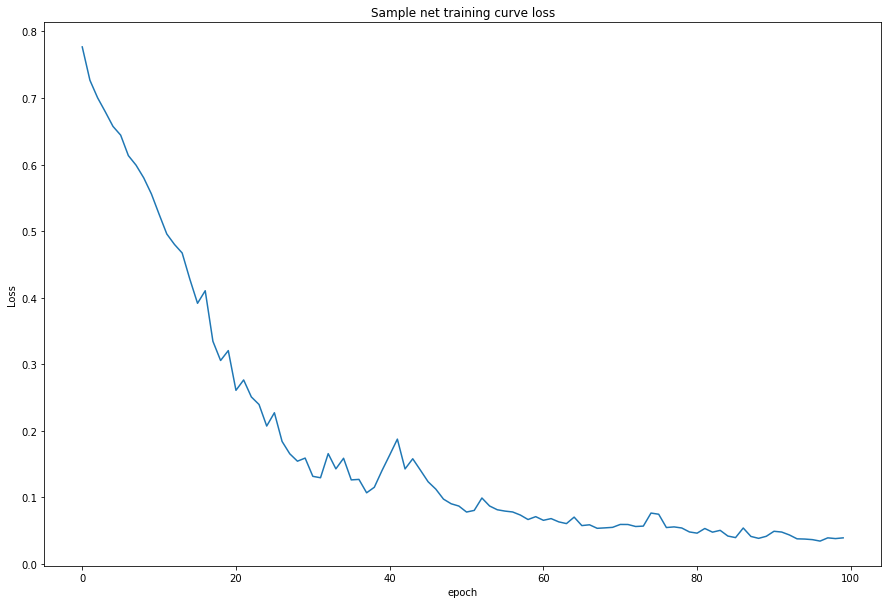

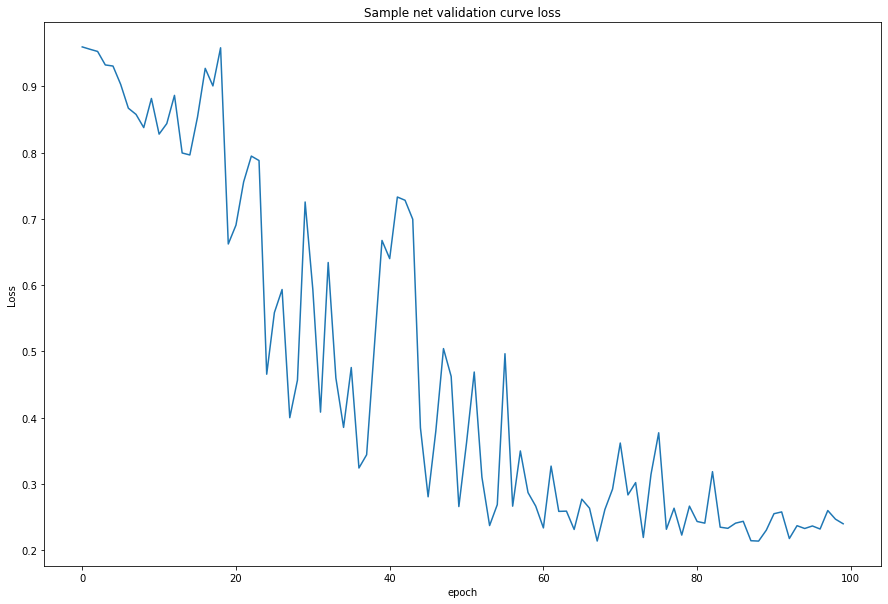

In [30]:
# Plot learning curves

#Training Loss curve
plt.plot(history.history["loss"])
plt.title("Sample net training curve loss")
plt.ylabel("Loss")
plt.xlabel("epoch")
plt.show()

#Validation Loss curve
plt.plot(history.history["val_loss"])
plt.title("Sample net validation curve loss")
plt.ylabel("Loss")
plt.xlabel("epoch")
plt.show()

## Testing the model

### LOAD MODELS FROM PREVIOUS SESSIONS 

In [37]:
# To load model weights from older runs, if present. If you do not have older runs, skip to the next cell
# Please load previous metrics and functions and other required variables.

best_model = UNet(loss=tversky_loss, lr=1e-3, filters=16,pretrained_weights=None, input_size=(PATCHSIZE, PATCHSIZE, NBANDS))
best_model.load_weights("D:Data/Checkpoints/weights.81-0.20.hdf5") # Load one from your checkpoints
results = best_model.evaluate(tf.cast(X_test, tf.float32), tf.cast(Y_test, tf.float32), verbose=0)
print(f'The metric evaluations are {results}')

best_model.save("D:Data/Checkpoints/model.hdf5") # This is to save the weights as a "model" h5 file type

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 128, 128, 5) 0                                            
__________________________________________________________________________________________________
conv2d_57 (Conv2D)              (None, 128, 128, 16) 736         input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_54 (BatchNo (None, 128, 128, 16) 64          conv2d_57[0][0]                  
__________________________________________________________________________________________________
activation_54 (Activation)      (None, 128, 128, 16) 0           batch_normalization_54[0][0]     
____________________________________________________________________________________________

### LOAD MODELS FROM CURRENT RUN (Current Session)

In [63]:
# To load model from current run
best_model.evaluate(tf.cast(X_test, tf.float32), tf.cast(Y_test, tf.float32), verbose=2)

5/5 - 0s - loss: 0.9734 - accuracy: 0.9498 - precision_m: 0.0838 - recall_m: 0.7973 - f1_m: 0.1458


[0.9733657836914062,
 0.9497690200805664,
 0.08378888666629791,
 0.7973179817199707,
 0.14582642912864685]

### Predict the model 

1/1 [==============================] - 10s 10s/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 13ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 14ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 15ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 17ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 14ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 16ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 16ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 14ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 19ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


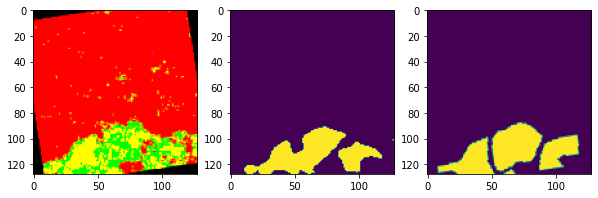

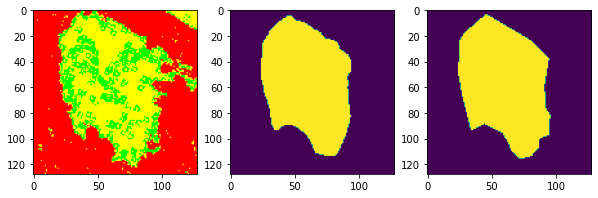

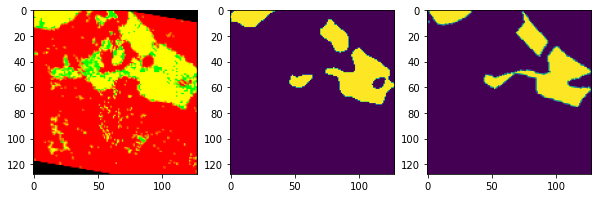

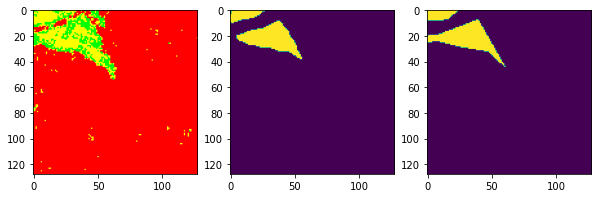

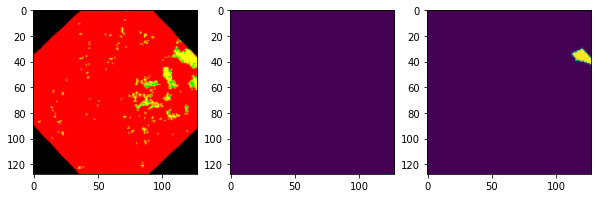

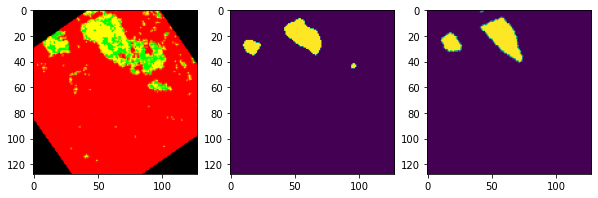

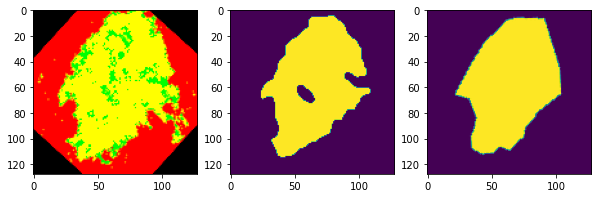

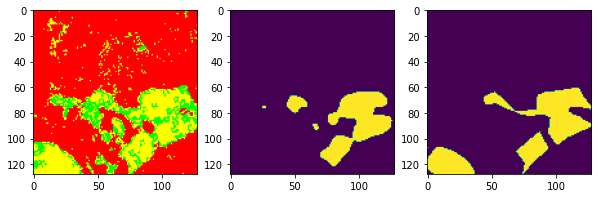

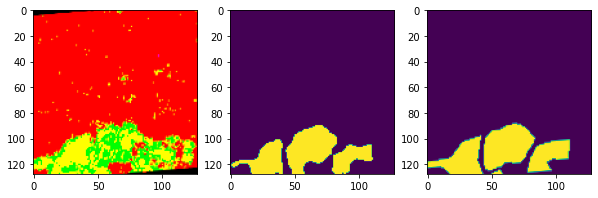

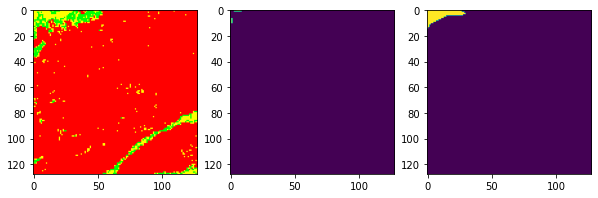

In [38]:
# Plot the first 10 predictions
for i in range(10):
    preds_train_1 = best_model.predict(np.expand_dims(X_test[i],axis = 0), verbose=1)
    # It's possible to change the 0.5 threshold to improve the results;
    preds_train_t1 = (preds_train_1 > 0.5).astype(np.uint8)
    f, axarr = plt.subplots(1,3,figsize=(10,10))
    axarr[0].imshow(X_test[i][:,:,:3])
    axarr[1].imshow(np.squeeze(preds_train_t1))
    axarr[2].imshow(np.squeeze(Y_test[i]))